Mass ratio for  2M17204248+4205070.tbl  is ??
Periodogram peaks above a power of 0.6: [ 1.43723176  3.29133525  3.71997207]


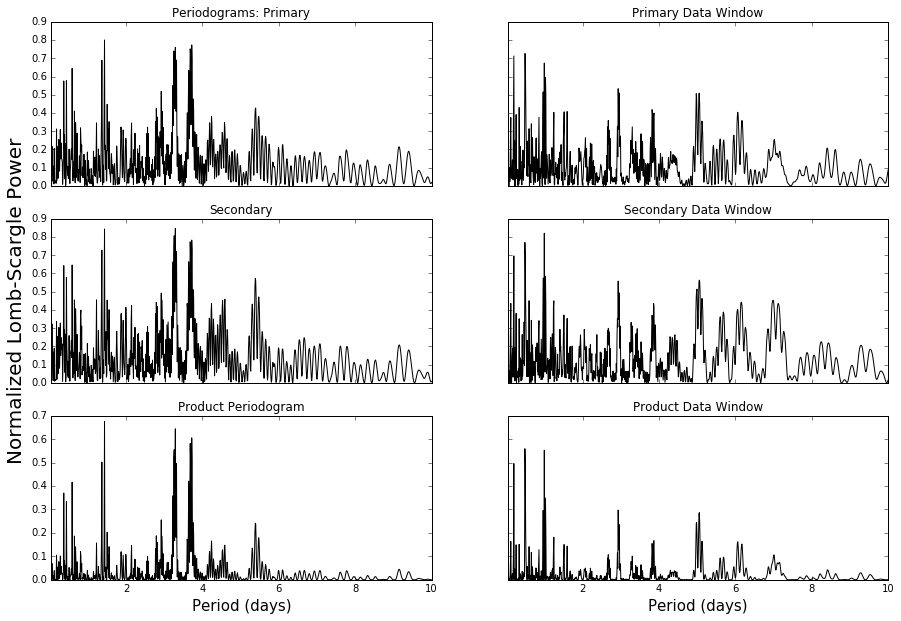

In [7]:
#import-libraries-and-data---------------------------------------------------------------------------------------#
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import lombscargle
from scipy import stats
import functions as f
%matplotlib inline
filename     = '2M17204248+4205070.tbl'
system       = np.genfromtxt(filename, skip_header=1, usecols=(0, 1, 2))

#define-variables------------------------------------------------------------------------------------------------#

JD, RVp, RVs = [datum[0] for datum in system], [datum[1] for datum in system], [datum[2] for datum in system]
JDp, JDs     = JD, JD
samples      = 1000
max_period   = 10

#define-functions------------------------------------------------------------------------------------------------#

periodogram = f.periodogram
dataWindow = f.dataWindow
maxima      = f.maxima
phases      = f.phases
massRatio   = f.massRatio
adjustment  = f.adjustment

#now-do-things!--------------------------------------------------------------------------------------------------#

#check RV measurements for the need to be adjusted and adjust them if so
for i in range(0, len(JD)-1):
    if np.isnan(system[i][1]):
        JDp, RVp = adjustment(JD, RVp)
        break
        
for i in range(0, len(JD)-1):
    if np.isnan(system[i][2]):
        JDs, RVs = adjustment(JD, RVs)
        break
        
# plot the results
x, y  = periodogram(JDp, RVp, samples, max_period)
y2    = periodogram(JDs, RVs, samples, max_period)[1]
y3,y4 = dataWindow(JDp, samples, max_period)[1], dataWindow(JDs, samples, max_period)[1]

fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3, 2, sharex='col', sharey='row')
ax1.plot(x, y, 'k')
ax1.set_title('Periodograms: Primary')
ax1.set_xlim(1/24, max_period)
ax4.set_xlim(1/24, max_period)
ax2.plot(x, y2, 'k')
ax2.set_title('Secondary')
ax3.plot(x, y*y2, 'k')
ax3.set_title('Product Periodogram')
ax4.plot(x, y3, 'k')
ax4.set_title('Primary Data Window')
ax5.plot(x, y4, 'k')
ax5.set_title('Secondary Data Window')
ax6.plot(x, y3*y4, 'k')
ax6.set_title('Product Data Window')
ax3.set_xlabel('Period (days)', size='15')
ax6.set_xlabel('Period (days)', size='15')
ax2.set_ylabel('Normalized Lomb-Scargle Power', size='20')
fig.set_figheight(10)
fig.set_figwidth(15)
#plt.savefig(filename + ' periodogram.pdf')
print('Mass ratio for ', filename, ' is ??')
print('Periodogram peaks above a power of 0.6:',maxima(0.6, x, y, y2))

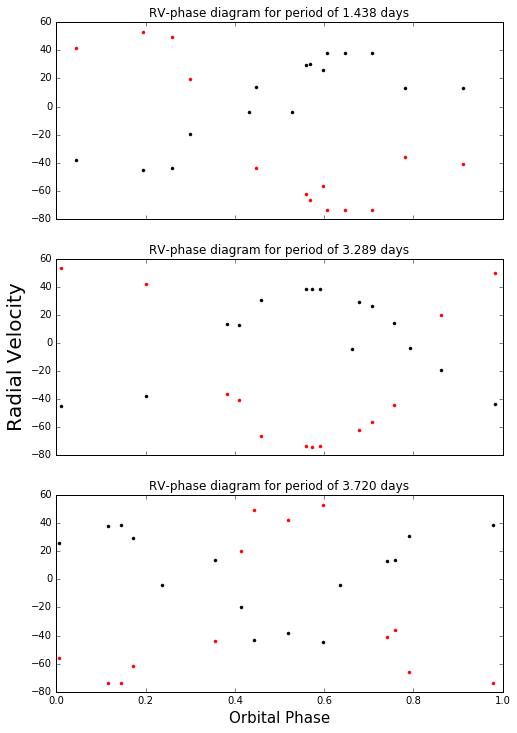

In [8]:
fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1, sharex='col', sharey='row')
ax1.plot(phases(maxima(0.6, x, y, y2)[0], 0, JDp), RVp, 'k.')
ax1.plot(phases(maxima(0.6, x, y, y2)[0], 0, JDs), RVs, 'r.')
ax1.set_title('RV-phase diagram for period of 1.438 days')
ax2.plot(phases(maxima(0.6, x, y, y2)[1], 0, JDp), RVp, 'k.')
ax2.plot(phases(maxima(0.6, x, y, y2)[1], 0, JDs), RVs, 'r.')
ax2.set_title('RV-phase diagram for period of 3.289 days')
ax3.plot(phases(maxima(0.6, x, y, y2)[2], 0, JDp), RVp, 'k.')
ax3.plot(phases(maxima(0.6, x, y, y2)[2], 0, JDs), RVs, 'r.')
ax3.set_title('RV-phase diagram for period of 3.720 days')
ax3.set_xlabel('Orbital Phase', size='15')
ax2.set_ylabel('Radial Velocity', size='20')
fig.set_figheight(12)
fig.set_figwidth(8)
#plt.savefig(filename + ' RV-phase diagram.pdf')

mass ratio is  0.643986286319 +/- 6.93427691827e-05


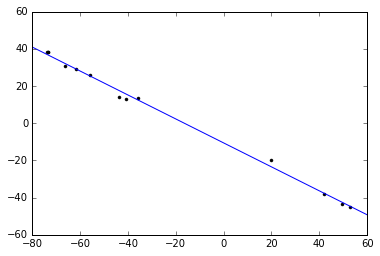

In [9]:
mass_ratio, intercept, r_squared, standard_error, slope_error = massRatio(RVs,RVp, system)
p = [datum[1] for datum in system if not np.isnan(datum[1]+datum[2])]
s = [datum[2] for datum in system if not np.isnan(datum[1]+datum[2])]
plt.plot(s, p, 'k.')
plt.plot(np.array([-80, 60]), -mass_ratio*np.array([-80, 60])+intercept)
print('mass ratio is ', mass_ratio, "+/-", slope_error)